# Sign Language Classifier


### Importing Library

In [2]:
import pandas as pd
import numpy as np

import cv2

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import  GridSearchCV
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import os
import csv

### Setting Directory location

In [3]:
# Get the current working directory
directory = os.getcwd()
directory = directory+"/"


### Load training and testing sets

In [4]:
train_file = directory+"sign_mnist_train.csv"
train_data = pd.read_csv(train_file)
print(train_data.head())

test_file = directory+"sign_mnist_test.csv"
test_data = pd.read_csv(test_file)
print(test_data.head())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783  pixel784  
0       206       204       20

### Investigate Datasets

In [5]:
def show_stats(labels):
  # Count the number of samples for each class
  class_counts = labels.value_counts().sort_index()

  # Add class 'Z' with zero count if it doesn't exist in the dataset
  class_counts = class_counts.reindex(range(26), fill_value=0)

  # Plot the distribution of samples for each class
  plt.figure(figsize=(10, 6))

  bars = plt.bar(class_counts.index, class_counts.values)
  plt.xlabel('Class (Letter)')
  plt.ylabel('Number of Samples')
  plt.title('Distribution of Samples for Each Class')

  # Set the x-axis limits to remove extra space on the right
  plt.xlim(-0.5, 25.5)

  # Label the x-axis with letters A-Z
  plt.xticks(range(26), [chr(ord('A') + i) for i in range(26)])

  for bar, count in zip(bars, class_counts.values):
      plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
              ha='center', va='bottom')
  plt.show()


  # Display other statistical information about the dataset
  print("Number of samples in the dataset:", len(labels))
  print("Number of classes in the dataset:", len(class_counts))
  print("Minimum number of samples in a class:", min(class_counts))
  print("Maximum number of samples in a class:", max(class_counts))
  print("Average number of samples per class:", round(class_counts.mean(), 2))
  print("Standard deviation of samples per class:", round(class_counts.std(), 2))

  # Count the occurrences of each label
  label_counts = labels.value_counts()
  # Find the outliers (labels outside the range of 0 to 25)
  outliers = label_counts[(label_counts.index < 0) | (label_counts.index > 25)]
  print("Outliers (Labels outside the range of 0 to 25):")
  print(outliers)

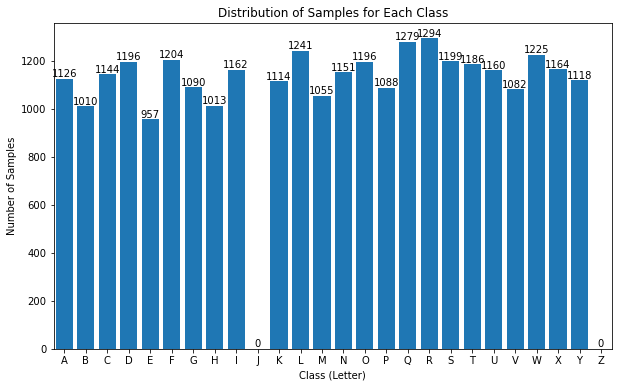

Number of samples in the dataset: 27455
Number of classes in the dataset: 26
Minimum number of samples in a class: 0
Maximum number of samples in a class: 1294
Average number of samples per class: 1055.92
Standard deviation of samples per class: 321.07
Outliers (Labels outside the range of 0 to 25):
200    1
Name: label, dtype: int64


In [6]:
show_stats(train_data['label'])

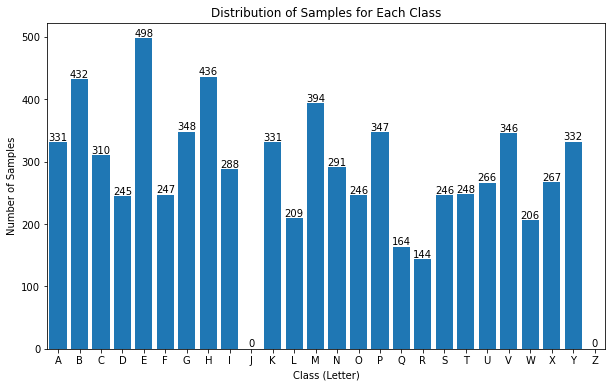

Number of samples in the dataset: 7172
Number of classes in the dataset: 26
Minimum number of samples in a class: 0
Maximum number of samples in a class: 498
Average number of samples per class: 275.85
Standard deviation of samples per class: 115.8
Outliers (Labels outside the range of 0 to 25):
Series([], Name: label, dtype: int64)


In [7]:
show_stats(test_data['label'])

### Display Samples from training set

[14577 13271 18347]


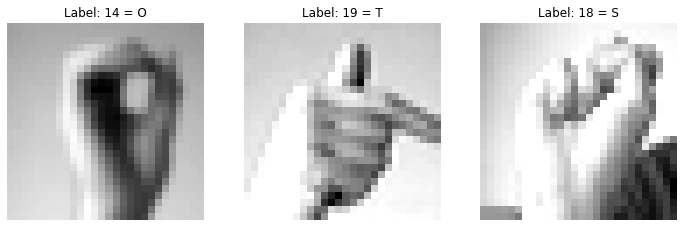

In [8]:
train_x = train_data.drop('label', axis=1).values
train_y = train_data['label']

random_indices = np.random.choice(len(train_x), 3, replace=False)
print(random_indices)
# Create a 1x3 subplot layout
plt.figure(figsize=(12, 4))

# Plot the original images
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(train_x[random_indices[i]].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {train_y[random_indices[i]]} = {chr(ord('A') + train_y[random_indices[i]])}")
    plt.axis('off')

plt.show()

### Cleaning Data (Removing bad data)



In [9]:
# Find the index of the outliers (labels outside the range of 0 to 25)
outliers_index = train_data['label'][(train_data['label'] < 0) | (train_data['label'] > 25)].index
print(outliers_index)
# Remove the outliers from the dataset
train_data = train_data.drop(outliers_index)

# Separate labels and pixel values from the updated training dataset
TRAIN_Y = train_data['label']
TRAIN_X = train_data.drop('label', axis=1).values


# Separate labels and pixel values from the updated testing dataset
TEST_Y = test_data['label']
TEST_X = test_data.drop('label', axis=1).values

Int64Index([498], dtype='int64')


### Train Test Validation Set prepare

In [10]:
def prep_datasets(TRAIN_X,TRAIN_Y,TEST_X,TEST_Y):
  train_x = TRAIN_X
  train_y = TRAIN_Y
  test_x = TEST_X
  test_y = TEST_Y

  # Normalize pixel values to the range [0, 1]
  train_x = train_x / 255.0
  test_x = test_x/255.0

  # Reshape the pixel values to 28x28 images with a single channel (grayscale)
  train_x = train_x.reshape(-1, 28, 28, 1)
  test_x = test_x.reshape(-1, 28, 28, 1)

  # Convert labels to one-hot encoded vectors

  train_y = tf.keras.utils.to_categorical(train_y, num_classes=26)
  test_y = tf.keras.utils.to_categorical(test_y, num_classes=26)

  # Split the dataset into testing and validation sets
  split_index = int(0.5 * len(test_y))
  test_x, val_x = test_x[:split_index], test_x[split_index:]
  test_y, val_y = test_y[:split_index], test_y[split_index:]

  return train_x,train_y,val_x,val_y,test_x,test_y

### Plotting learning curve

In [11]:
def plt_curve(history,path):

  plt.figure(figsize=(10, 6))
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Learning Curve')
  plt.legend()
  plt.grid(True)
  LR_curve_path = path + "_Learning_curve.png"
  plt.savefig(LR_curve_path)
  plt.show()

###  Evaluate the model on the Testing set





In [12]:

def model_eval(path,model,test_x,test_y):

  # Generate predictions on the validation set
  y_pred = model.predict(test_x)
  y_pred_classes = np.argmax(y_pred, axis=1)

  # Convert one-hot encoded labels back to integer labels for the test set
  y_test_int = np.argmax(test_y, axis=1)

  # Print Average test Accuracy
  print(f"Test Accuracy: {accuracy_score(y_test_int, y_pred_classes)} ")

  # Generate the classification report
  class_names = [chr(ord('A') + i) for i in range(26)]
  class_names = np.delete(class_names,[9, 25])

  print("Classification Report:")
  report = classification_report(np.argmax(test_y, axis=1), y_pred_classes, target_names=class_names)
  print(report)
  # Generate the confusion matrix
  conf_matrix = confusion_matrix(np.argmax(test_y, axis=1), y_pred_classes)

  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
    
  confusion_matrix_path = path + "_confusion_matrix.png"
  plt.savefig(confusion_matrix_path)
  plt.show()

  # Calculate individual accuracy for each class
  individual_accuracies = {}
  for i in range(26):
      true_indices = np.where(y_test_int == i)
      class_accuracy = accuracy_score(y_test_int[true_indices], y_pred_classes[true_indices])
      individual_accuracies[chr(ord('A') + i)] = class_accuracy
      print(f"{chr(ord('A') + i)}: {class_accuracy:.4f}")
      i=i+1
  
  save_evaluation_results(path,individual_accuracies,conf_matrix,report,class_names)
  # Metrices for comparison
  precision = precision_score(y_test_int, y_pred_classes, average='macro')
  recall = recall_score(y_test_int, y_pred_classes, average='macro')
  f1 = f1_score(y_test_int, y_pred_classes, average='macro')
  accuracy = accuracy_score(y_test_int, y_pred_classes)
  return [precision,recall,f1,accuracy]


### Save Results in storage


In [13]:
def save_evaluation_results(path, classwise_accuracies, cm, report, labels):
    # Save classification report to a text file
    with open(path + "_classification_report.txt", "w") as report_file:
        report_file.write(report)


    # Convert class-wise accuracies to a DataFrame
    accuracies_df = pd.DataFrame(classwise_accuracies.items(), columns=['Letter', 'Accuracy'])

    # Save classification report and class-wise accuracies to CSV files
    #report_df.to_csv(file_path + "_classification_report.csv", index=True)
    accuracies_df.to_csv(path + "_classwise_accuracies.csv", index=False)

    print("Classification report, class-wise accuracies, and confusion matrix plot saved.")

### Training Baseline CNN Model

Epoch 1/50
429/429 [==============================] - 6s 13ms/step - loss: 1.1615 - accuracy: 0.6325 - val_loss: 0.3961 - val_accuracy: 0.8798
Epoch 2/50
429/429 [==============================] - 5s 12ms/step - loss: 0.1092 - accuracy: 0.9660 - val_loss: 0.2824 - val_accuracy: 0.9267
Epoch 3/50
429/429 [==============================] - 5s 12ms/step - loss: 0.0296 - accuracy: 0.9921 - val_loss: 0.2984 - val_accuracy: 0.9322
Epoch 4/50
429/429 [==============================] - 5s 12ms/step - loss: 0.0261 - accuracy: 0.9922 - val_loss: 0.2537 - val_accuracy: 0.9387
Epoch 5/50
429/429 [==============================] - 5s 12ms/step - loss: 0.0147 - accuracy: 0.9955 - val_loss: 0.2581 - val_accuracy: 0.9417
Epoch 6/50
429/429 [==============================] - 5s 12ms/step - loss: 0.0086 - accuracy: 0.9978 - val_loss: 0.3436 - val_accuracy: 0.9375
Epoch 7/50
429/429 [==============================] - 5s 12ms/step - loss: 0.0120 - accuracy: 0.9964 - val_loss: 0.3234 - val_accuracy: 0.9529

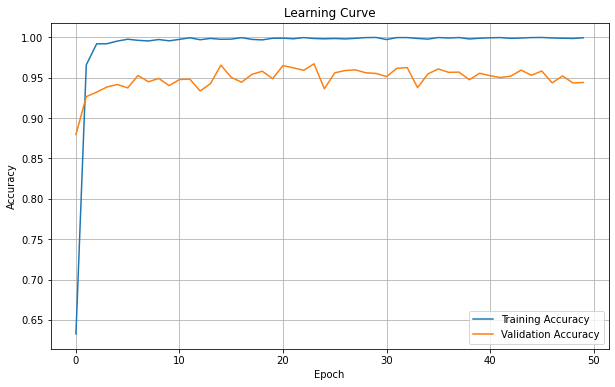

Test Accuracy: 0.9408812046848857 
Classification Report:
              precision    recall  f1-score   support

           A       0.89      1.00      0.94       154
           B       1.00      0.96      0.98       220
           C       0.97      1.00      0.98       156
           D       1.00      1.00      1.00       118
           E       0.95      0.87      0.91       254
           F       0.99      1.00      1.00       124
           G       0.94      0.88      0.91       164
           H       0.93      0.96      0.94       219
           I       0.86      1.00      0.93       134
           K       0.94      1.00      0.97       171
           L       0.92      1.00      0.96       109
           M       0.94      0.89      0.92       195
           N       0.90      0.86      0.88       140
           O       1.00      0.94      0.97       127
           P       0.95      0.99      0.97       171
           Q       1.00      1.00      1.00        81
           R       0.78

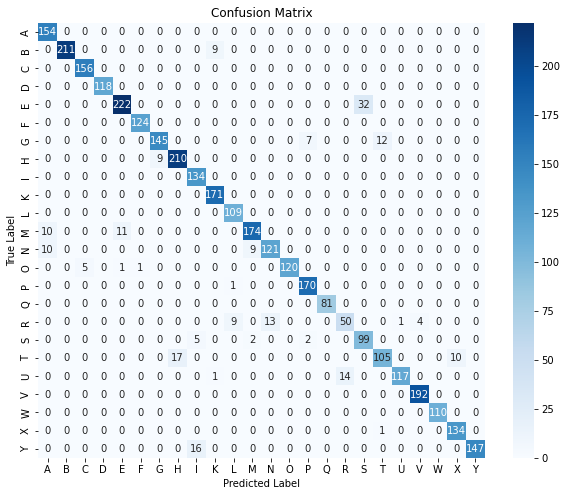

A: 1.0000
B: 0.9591
C: 1.0000
D: 1.0000
E: 0.8740
F: 1.0000
G: 0.8841
H: 0.9589
I: 1.0000
J: nan
K: 1.0000
L: 1.0000
M: 0.8923
N: 0.8643
O: 0.9449
P: 0.9942
Q: 1.0000
R: 0.6494
S: 0.9167
T: 0.7955
U: 0.8864
V: 1.0000
W: 1.0000
X: 0.9926
Y: 0.9018
Z: nan
Classification report, class-wise accuracies, and confusion matrix plot saved.


C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [54]:
# Load datasets
train_x,train_y,val_x,val_y,test_x,test_y = prep_datasets(TRAIN_X,TRAIN_Y,TEST_X,TEST_Y)

subdirectory ="Results/Bechmark_CNN"

path = os.path.join(directory, subdirectory)

# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(500, activation='relu'),
    layers.Dropout(.35),
    layers.Dense(26, activation='softmax')  # Output layer with 26 classes (letters A-Z)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Add ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(str(path+'_CNN_best_model.h5'), monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
epochs = 50
batch_size = 64
history = model.fit(train_x, train_y, validation_data=(val_x, val_y),callbacks=[ model_checkpoint], epochs=epochs, batch_size=batch_size)

model = tf.keras.models.load_model(path+'_CNN_best_model.h5')

print(path)
# Plot the learning curve
plt_curve(history,path)


# Model performance Evaluation
cnn_res = model_eval(path,model,test_x,test_y)

### The clients Metrices:
Model: Benchmark CNN with standerd training and testing set

**unbiased accuracy** estimate of a deep learning model: **94.09%**

the letter with the **lowest individual accuracy**: **64.94%  For letter R**

the most **common error**: **Confussion between E and S**(32 instances, Evidednt from the Confussion metrix)

###  Training baseline densely connected Neural netwrok

Epoch 1/50
429/429 [==============================] - 5s 11ms/step - loss: 2.2348 - accuracy: 0.2874 - val_loss: 1.7277 - val_accuracy: 0.4264
Epoch 2/50
429/429 [==============================] - 5s 11ms/step - loss: 1.1902 - accuracy: 0.5895 - val_loss: 1.3419 - val_accuracy: 0.5597
Epoch 3/50
429/429 [==============================] - 4s 10ms/step - loss: 0.6554 - accuracy: 0.7713 - val_loss: 1.0852 - val_accuracy: 0.6403
Epoch 4/50
429/429 [==============================] - 4s 10ms/step - loss: 0.3659 - accuracy: 0.8754 - val_loss: 1.1871 - val_accuracy: 0.7011
Epoch 5/50
429/429 [==============================] - 4s 9ms/step - loss: 0.2099 - accuracy: 0.9319 - val_loss: 1.1864 - val_accuracy: 0.7262
Epoch 6/50
429/429 [==============================] - 4s 9ms/step - loss: 0.1156 - accuracy: 0.9649 - val_loss: 1.2078 - val_accuracy: 0.7451
Epoch 7/50
429/429 [==============================] - 4s 10ms/step - loss: 0.1210 - accuracy: 0.9609 - val_loss: 1.3164 - val_accuracy: 0.7189
E

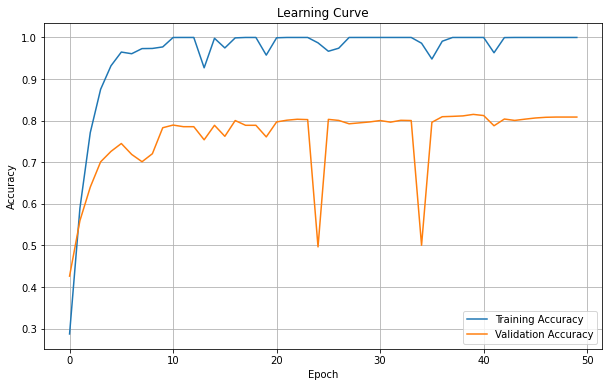

Test Accuracy: 0.7975460122699386 
Classification Report:
              precision    recall  f1-score   support

           A       0.81      1.00      0.89       154
           B       1.00      0.92      0.96       220
           C       0.83      0.98      0.90       156
           D       0.87      0.78      0.82       118
           E       0.91      1.00      0.95       254
           F       0.77      0.93      0.84       124
           G       0.90      0.78      0.84       164
           H       0.96      0.96      0.96       219
           I       0.90      0.78      0.84       134
           K       0.65      0.59      0.62       171
           L       0.84      0.98      0.90       109
           M       0.77      0.83      0.80       195
           N       0.91      0.41      0.57       140
           O       0.93      0.83      0.88       127
           P       0.95      0.95      0.95       171
           Q       0.67      0.84      0.74        81
           R       0.40

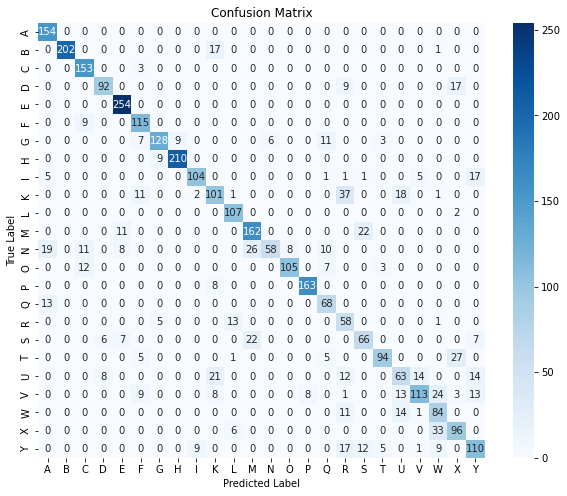

A: 1.0000
B: 0.9182
C: 0.9808
D: 0.7797
E: 1.0000
F: 0.9274
G: 0.7805
H: 0.9589
I: 0.7761
J: nan
K: 0.5906
L: 0.9817
M: 0.8308
N: 0.4143
O: 0.8268
P: 0.9532
Q: 0.8395
R: 0.7532
S: 0.6111
T: 0.7121
U: 0.4773
V: 0.5885
W: 0.7636
X: 0.7111
Y: 0.6748
Z: nan
Classification report, class-wise accuracies, and confusion matrix plot saved.


C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [55]:
train_x,train_y,val_x,val_y,test_x,test_y = prep_datasets(TRAIN_X,TRAIN_Y,TEST_X,TEST_Y)

subdirectory ="Results/Bechmark_DCNN"

path = os.path.join(directory, subdirectory)

# Build the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),  # Flatten the 28x28 images to a 1D array
    tf.keras.layers.Dense(512, activation='relu'),  # Fully connected layer with 512 units and ReLU activation
    tf.keras.layers.Dense(256, activation='relu'),  # Fully connected layer with 256 units and ReLU activation
    tf.keras.layers.Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
    tf.keras.layers.Dense(64, activation='relu'),  # Fully connected layer with 64 units and ReLU activation
    tf.keras.layers.Dense(26, activation='softmax')  # Output layer with 26 classes (letters A-Z)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_checkpoint = ModelCheckpoint(str(path+'_DCNN_best_model.h5'), monitor='val_accuracy', save_best_only=True, mode='max')
# Train the model
epochs = 50
batch_size = 64
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), callbacks=[ model_checkpoint],epochs=epochs, batch_size=batch_size)

# Plot the learning curve
plt_curve(history,path)

model = tf.keras.models.load_model(path+'_DCNN_best_model.h5')

# Model performance Evaluation
dcnn_res = model_eval(path,model,test_x,test_y)

### The clients Metrices:
Model: Benchmark DCNN with standerd training and testing set

unbiased accuracy estimate of the deep learning model: **79.76%**

the letter with the lowest individual accuracy: **41.43%  For letter N**

the most common error: **Confussion between R and K**(37 instances, Evident from the Confussion metrix)

### Optimization Attempt 1 (Using Thresholding to Highlight the foreground and Remove Backgraound)

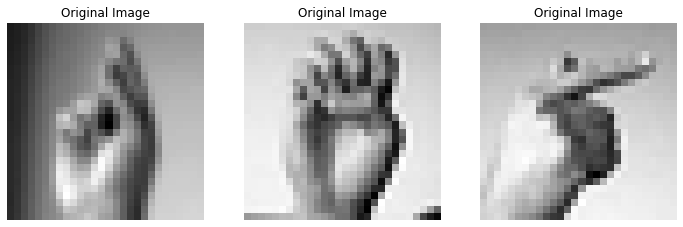

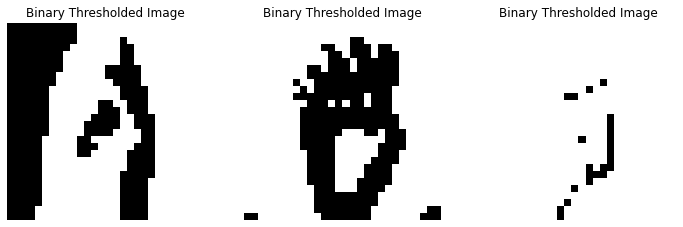

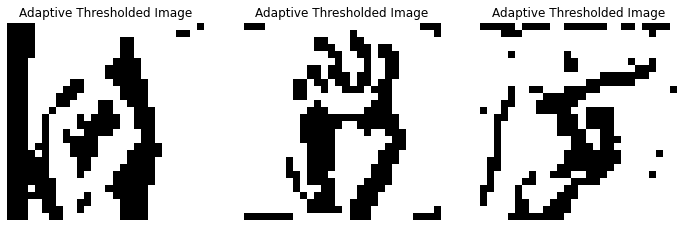

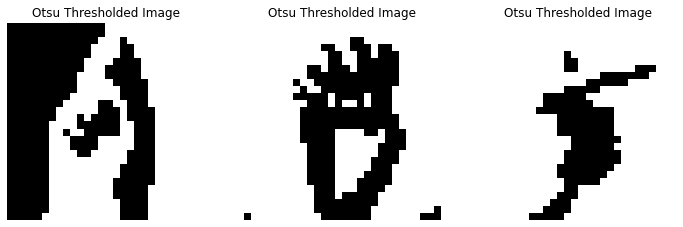

In [56]:
# Function to apply binary thresholding to an image
def apply_binary_threshold(image, threshold=128):
    _, binary_image = cv2.threshold((image * 255).astype(np.uint8), threshold, 1, cv2.THRESH_BINARY)
    return binary_image

# Function to apply Otsu's thresholding to an image
def apply_otsu_threshold(image):
    _, binary_image = cv2.threshold((image * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

# Function to apply adaptive thresholding to an image
def apply_adaptive_threshold(image, block_size=11, constant=2):
    binary_image = cv2.adaptiveThreshold((image * 255).astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, block_size, constant)
    return binary_image

random_indices = np.random.choice(len(train_x), 3, replace=False)

# Create a 1x3 subplot layout
plt.figure(figsize=(12, 4))

# Plot the original images
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(train_x[random_indices[i]].reshape(28, 28), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

plt.show()

# Create another 1x3 subplot layout for the binary thresholded images
plt.figure(figsize=(12, 4))

# Plot the binary thresholded images using binary thresholding
for i in range(3):
    plt.subplot(1, 3, i + 1)
    binary_image = apply_binary_threshold(train_x[random_indices[i]].reshape(28, 28))
    plt.imshow(binary_image, cmap='gray')
    plt.title('Binary Thresholded Image')
    plt.axis('off')

plt.show()

# Create another 1x3 subplot layout for the adaptive thresholded images
plt.figure(figsize=(12, 4))

# Plot the binary thresholded images using adaptive thresholding
for i in range(3):
    plt.subplot(1, 3, i + 1)
    binary_image = apply_adaptive_threshold(train_x[random_indices[i]].reshape(28, 28))
    plt.imshow(binary_image, cmap='gray')
    plt.title('Adaptive Thresholded Image')
    plt.axis('off')

plt.show()


# Create another 1x3 subplot layout for the otsu thresholded images
plt.figure(figsize=(12, 4))

# Plot the binary thresholded images using otsu thresholding
for i in range(3):
    plt.subplot(1, 3, i + 1)
    binary_image = apply_otsu_threshold(train_x[random_indices[i]].reshape(28, 28))
    plt.imshow(binary_image, cmap='gray')
    plt.title('Otsu Thresholded Image')
    plt.axis('off')

plt.show()

#### Observations
As we can see otsu thresholding is perfoprms the best.

#### Implementing CNN with Otsu threshloding


Epoch 1/50
429/429 [==============================] - 6s 13ms/step - loss: 0.5800 - accuracy: 0.8162 - val_loss: 0.3228 - val_accuracy: 0.8910
Epoch 2/50
429/429 [==============================] - 5s 12ms/step - loss: 0.0365 - accuracy: 0.9899 - val_loss: 0.4323 - val_accuracy: 0.8781
Epoch 3/50
429/429 [==============================] - 5s 12ms/step - loss: 0.0207 - accuracy: 0.9938 - val_loss: 0.4098 - val_accuracy: 0.9044
Epoch 4/50
429/429 [==============================] - 5s 12ms/step - loss: 0.0121 - accuracy: 0.9961 - val_loss: 0.3845 - val_accuracy: 0.9083
Epoch 5/50
429/429 [==============================] - 5s 13ms/step - loss: 0.0072 - accuracy: 0.9979 - val_loss: 0.3879 - val_accuracy: 0.9077
Epoch 6/50
429/429 [==============================] - 5s 12ms/step - loss: 0.0128 - accuracy: 0.9964 - val_loss: 0.4012 - val_accuracy: 0.9052
Epoch 7/50
429/429 [==============================] - 5s 12ms/step - loss: 0.0062 - accuracy: 0.9980 - val_loss: 0.2865 - val_accuracy: 0.9322

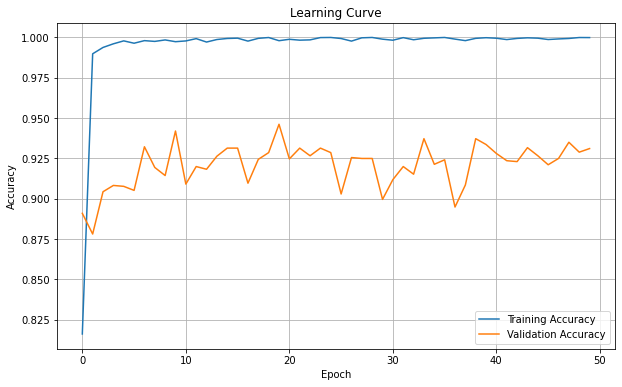

Test Accuracy: 0.9294478527607362 
Classification Report:
              precision    recall  f1-score   support

           A       0.99      1.00      1.00       154
           B       1.00      0.99      0.99       220
           C       0.93      1.00      0.96       156
           D       0.94      0.99      0.96       118
           E       0.96      1.00      0.98       254
           F       1.00      1.00      1.00       124
           G       0.82      0.75      0.78       164
           H       0.93      0.96      0.94       219
           I       0.83      1.00      0.91       134
           K       0.94      0.91      0.93       171
           L       0.99      1.00      1.00       109
           M       0.86      0.92      0.89       195
           N       0.99      0.71      0.83       140
           O       0.99      0.89      0.94       127
           P       0.92      0.98      0.95       171
           Q       1.00      1.00      1.00        81
           R       0.69

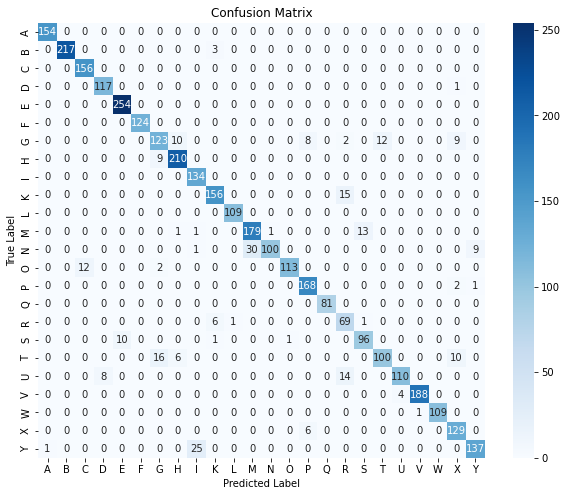

A: 1.0000
B: 0.9864
C: 1.0000
D: 0.9915
E: 1.0000
F: 1.0000
G: 0.7500
H: 0.9589
I: 1.0000
J: nan
K: 0.9123
L: 1.0000
M: 0.9179
N: 0.7143
O: 0.8898
P: 0.9825
Q: 1.0000
R: 0.8961
S: 0.8889
T: 0.7576
U: 0.8333
V: 0.9792
W: 0.9909
X: 0.9556
Y: 0.8405
Z: nan
Classification report, class-wise accuracies, and confusion matrix plot saved.


C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [57]:
AUG_TRAIN_X = np.array([apply_otsu_threshold(image.reshape(28, 28)) for image in TRAIN_X])

AUG_TEST_X = np.array([apply_otsu_threshold(image.reshape(28, 28)) for image in TEST_X])

train_x,train_y,val_x,val_y,test_x,test_y = prep_datasets(AUG_TRAIN_X,TRAIN_Y,AUG_TEST_X,TEST_Y)

subdirectory ="Results/AUG_CNN"

path = os.path.join(directory, subdirectory)

# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(500, activation='relu'),
    layers.Dropout(.35),
    layers.Dense(26, activation='softmax')  # Output layer with 26 classes (letters A-Z)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_checkpoint = ModelCheckpoint(str(path+'AUG_best_model.h5'), monitor='val_accuracy', save_best_only=True, mode='max')
# Train the model
epochs = 50
batch_size = 64
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), callbacks=[ model_checkpoint],epochs=epochs, batch_size=batch_size)

model = tf.keras.models.load_model(path+'AUG_best_model.h5')


# Plot the learning curve
plt_curve(history,path)


# Model performance Evaluation
aug_res =model_eval(path,model,test_x,test_y)

### The clients Metrices:
Model: Benchmark CNN with Augmented training and testing set

unbiased accuracy estimate of a deep learning model: **92.95%**

the letter with the lowest individual accuracy: **71.43%  For letter N**

the most common error: **Confussion between Y and I**(25 instances, Evident from the Confussion metrix)

### Optimization Attempt 2 Using Grid Search to find best training Paramater

In [58]:
train_x,train_y,val_x,val_y,test_x,test_y = prep_datasets(TRAIN_X,TRAIN_Y,TEST_X,TEST_Y)


# Define the CNN model
def create_cnn_model(optimizer='adam', learn_rate=0.01):
    model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(500, activation='relu'),
    layers.Dropout(.35),
    layers.Dense(26, activation='softmax')  # Output layer with 26 classes (letters A-Z)
    ])

    if optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learn_rate)
    elif optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)


    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [59]:

# Create the KerasClassifier for use with GridSearchCV
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_cnn_model,  epochs=5, batch_size=64, verbose=1)

# Define the hyperparameter grid to search
param_grid = {
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'learn_rate': [.001, .01, .005]
}


# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the grid search on the training data
grid_result = grid_search.fit(train_x, train_y)

# Get the best hyperparameters
best_params = grid_result.best_params_

# Print the best hyperparameters
print("Best Hyperparameters: ", best_params)



Fitting 3 folds for each of 9 candidates, totalling 27 fits
Epoch 1/5
286/286 [==============================] - 4s 12ms/step - loss: 1.5366 - accuracy: 0.5254
Epoch 2/5
286/286 [==============================] - 3s 12ms/step - loss: 0.2566 - accuracy: 0.9141
Epoch 3/5
286/286 [==============================] - 3s 12ms/step - loss: 0.0732 - accuracy: 0.9787
Epoch 4/5
286/286 [==============================] - 3s 12ms/step - loss: 0.0360 - accuracy: 0.9897
Epoch 5/5
143/143 [==============================] - 1s 6ms/step - loss: 0.0045 - accuracy: 0.9997
Epoch 1/5
286/286 [==============================] - 4s 13ms/step - loss: 1.6419 - accuracy: 0.4809
Epoch 2/5
286/286 [==============================] - 3s 11ms/step - loss: 0.3018 - accuracy: 0.8997
Epoch 3/5
286/286 [==============================] - 3s 11ms/step - loss: 0.0985 - accuracy: 0.9695
Epoch 4/5
286/286 [==============================] - 3s 12ms/step - loss: 0.0472 - accuracy: 0.9858
Epoch 5/5
143/143 [======================

429/429 [==============================] - 5s 11ms/step - loss: 0.0180 - accuracy: 0.9953
Epoch 5/5
429/429 [==============================] - 5s 12ms/step - loss: 0.0147 - accuracy: 0.9961
Best Hyperparameters:  {'learn_rate': 0.001, 'optimizer': 'rmsprop'}


Epoch 1/50
429/429 [==============================] - 7s 14ms/step - loss: 1.2412 - accuracy: 0.6093 - val_loss: 0.4120 - val_accuracy: 0.8634
Epoch 2/50
429/429 [==============================] - 5s 13ms/step - loss: 0.1429 - accuracy: 0.9539 - val_loss: 0.2872 - val_accuracy: 0.9191
Epoch 3/50
429/429 [==============================] - 5s 12ms/step - loss: 0.0364 - accuracy: 0.9903 - val_loss: 0.2543 - val_accuracy: 0.9481
Epoch 4/50
429/429 [==============================] - 5s 13ms/step - loss: 0.0220 - accuracy: 0.9937 - val_loss: 0.3056 - val_accuracy: 0.9261
Epoch 5/50
429/429 [==============================] - 6s 13ms/step - loss: 0.0122 - accuracy: 0.9969 - val_loss: 0.2880 - val_accuracy: 0.9490
Epoch 6/50
429/429 [==============================] - 6s 13ms/step - loss: 0.0187 - accuracy: 0.9944 - val_loss: 0.2652 - val_accuracy: 0.9467
Epoch 7/50
429/429 [==============================] - 5s 12ms/step - loss: 0.0117 - accuracy: 0.9965 - val_loss: 0.2930 - val_accuracy: 0.9537

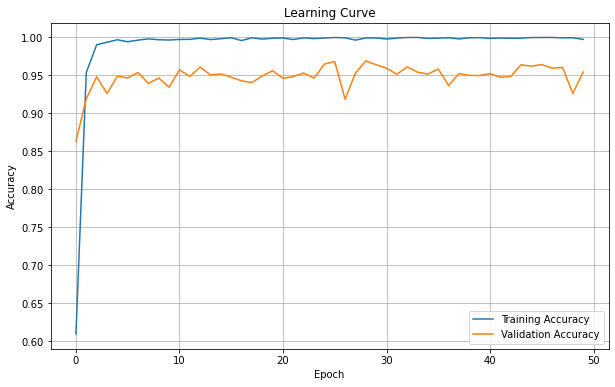

Test Accuracy: 0.9665365309537088 
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       154
           B       1.00      1.00      1.00       220
           C       1.00      1.00      1.00       156
           D       0.99      1.00      1.00       118
           E       1.00      1.00      1.00       254
           F       1.00      1.00      1.00       124
           G       0.88      0.96      0.92       164
           H       1.00      0.96      0.98       219
           I       0.89      0.92      0.90       134
           K       0.99      0.96      0.98       171
           L       1.00      1.00      1.00       109
           M       0.90      0.94      0.92       195
           N       1.00      0.86      0.92       140
           O       1.00      0.90      0.95       127
           P       1.00      1.00      1.00       171
           Q       1.00      1.00      1.00        81
           R       1.00

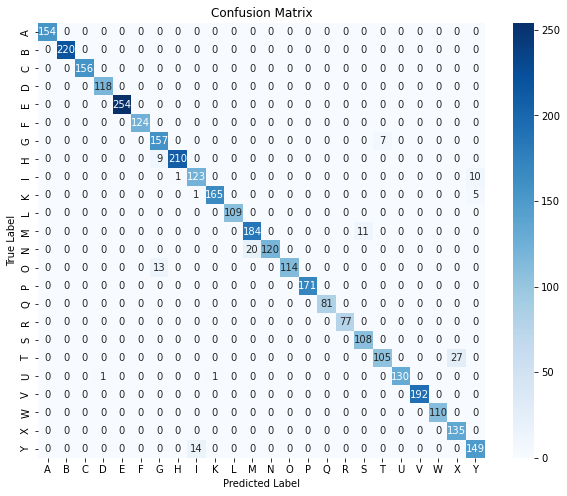

A: 1.0000
B: 1.0000
C: 1.0000
D: 1.0000
E: 1.0000
F: 1.0000
G: 0.9573
H: 0.9589
I: 0.9179
J: nan
K: 0.9649
L: 1.0000
M: 0.9436
N: 0.8571
O: 0.8976
P: 1.0000
Q: 1.0000
R: 1.0000
S: 1.0000
T: 0.7955
U: 0.9848
V: 1.0000
W: 1.0000
X: 1.0000
Y: 0.9141
Z: nan
Classification report, class-wise accuracies, and confusion matrix plot saved.


C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [60]:
# Evaluate the model on the validation set with the best hyperparameters  {'activation': 'relu', 'optimizer': 'rmsprop'}
#best_params = {'optimizer':'rmsprop','learn_rate': .001}

subdirectory ="Results/Tuned_CNN"

path = os.path.join(directory, subdirectory)

best_model = create_cnn_model(optimizer=best_params['optimizer'], learn_rate=best_params['learn_rate'])

# Add Early Stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Add ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(str(path+'Tuned_CNN_best_model.h5'), monitor='val_accuracy', save_best_only=True, mode='max')

history = best_model.fit(train_x, train_y, validation_data=(val_x, val_y), callbacks=[model_checkpoint],epochs=50, batch_size=64, verbose=1)

model = tf.keras.models.load_model(path+'Tuned_CNN_best_model.h5')

#path = directory+ "Tuned_CNN"
# Plot the learning curve
plt_curve(history,path)


# Model performance Evaluation
tuned_res = model_eval(path,model,test_x,test_y)


### The clients Metrices:
Model: Benchmark CNN with Grid Searched parameter

unbiased accuracy estimate of a deep learning model: **96.65%**

the letter with the lowest individual accuracy: **79.55%  For letter T**

the most common error: **Confussion between T and X**(27 instances, Evident from the Confussion metrix)

### Optimization Attempt 3 increasing the complexity of the model

Epoch 1/50
429/429 [==============================] - 10s 19ms/step - loss: 1.7295 - accuracy: 0.4494 - val_loss: 0.5132 - val_accuracy: 0.8291
Epoch 2/50
429/429 [==============================] - 8s 18ms/step - loss: 0.2036 - accuracy: 0.9316 - val_loss: 0.3666 - val_accuracy: 0.8929
Epoch 3/50
429/429 [==============================] - 8s 18ms/step - loss: 0.0560 - accuracy: 0.9828 - val_loss: 0.7874 - val_accuracy: 0.8461
Epoch 4/50
429/429 [==============================] - 8s 18ms/step - loss: 0.0337 - accuracy: 0.9908 - val_loss: 0.2970 - val_accuracy: 0.9381
Epoch 5/50
429/429 [==============================] - 8s 18ms/step - loss: 0.0231 - accuracy: 0.9931 - val_loss: 0.4212 - val_accuracy: 0.9294
Epoch 6/50
429/429 [==============================] - 8s 18ms/step - loss: 0.0232 - accuracy: 0.9946 - val_loss: 0.3676 - val_accuracy: 0.9311
Epoch 7/50
429/429 [==============================] - 8s 18ms/step - loss: 0.0178 - accuracy: 0.9957 - val_loss: 0.4238 - val_accuracy: 0.941

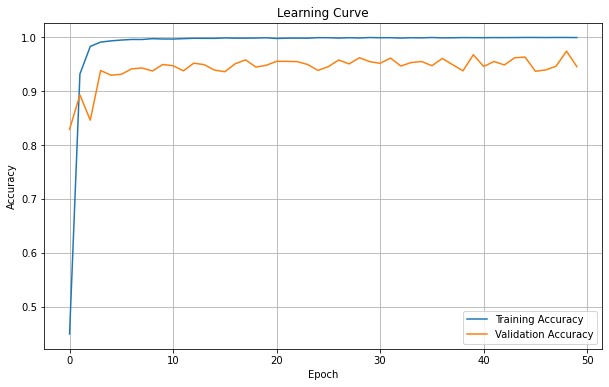

Test Accuracy: 0.9673731176798661 
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       154
           B       1.00      1.00      1.00       220
           C       0.95      1.00      0.97       156
           D       1.00      1.00      1.00       118
           E       0.96      1.00      0.98       254
           F       1.00      1.00      1.00       124
           G       0.87      1.00      0.93       164
           H       1.00      0.91      0.95       219
           I       0.86      0.99      0.92       134
           K       0.86      0.94      0.90       171
           L       1.00      0.99      1.00       109
           M       0.94      0.94      0.94       195
           N       1.00      0.91      0.96       140
           O       1.00      0.91      0.95       127
           P       0.94      1.00      0.97       171
           Q       1.00      1.00      1.00        81
           R       1.00

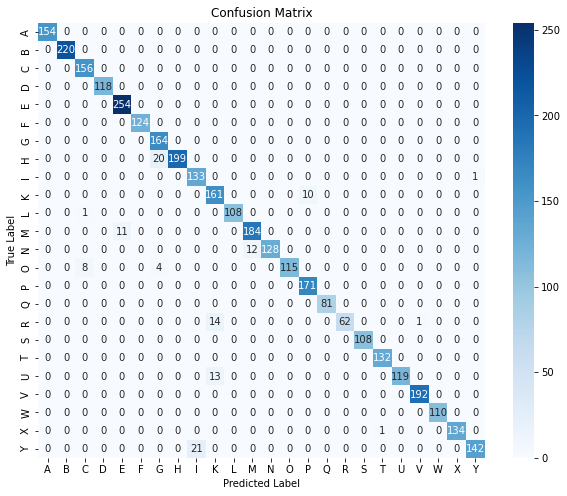

A: 1.0000
B: 1.0000
C: 1.0000
D: 1.0000
E: 1.0000
F: 1.0000
G: 1.0000
H: 0.9087
I: 0.9925
J: nan
K: 0.9415
L: 0.9908
M: 0.9436
N: 0.9143
O: 0.9055
P: 1.0000
Q: 1.0000
R: 0.8052
S: 1.0000
T: 1.0000
U: 0.9015
V: 1.0000
W: 1.0000
X: 0.9926
Y: 0.8712
Z: nan
Classification report, class-wise accuracies, and confusion matrix plot saved.


C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [61]:
def create_complex_cnn_model(optimizer='adam', learn_rate=0.01):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),  # Additional convolutional layer
        layers.MaxPooling2D((2, 2)),

        #layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Conv2D(128, (3, 3), activation='relu'),  # Additional convolutional layer
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

        layers.Dense(500, activation='relu'),
        layers.Dropout(0.5),  # Adding dropout for regularization

        layers.Dense(256, activation='relu'),  # Additional dense layer
        layers.Dropout(0.3),  # Adding dropout for regularization

        layers.Dense(26, activation='softmax')  # Output layer with 26 classes (letters A-Z)
    ])

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model
train_x,train_y,val_x,val_y,test_x,test_y = prep_datasets(TRAIN_X,TRAIN_Y,TEST_X,TEST_Y)
# Evaluate the model on the validation set with the best hyperparameters  {'activation': 'relu', 'optimizer': 'rmsprop'}
# best_params = {'optimizer':'rmsprop','learn_rate': .001}

subdirectory ="Results/Complex_CNN"

path = os.path.join(directory, subdirectory)

best_model = create_complex_cnn_model(optimizer=best_params['optimizer'], learn_rate=best_params['learn_rate'])

# Add Early Stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Add ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(str(path+'complex_best_model.h5'), monitor='val_accuracy', save_best_only=True, mode='max')

history = best_model.fit(train_x, train_y, validation_data=(val_x, val_y), callbacks=[ model_checkpoint],epochs=50, batch_size=64, verbose=1)

model = tf.keras.models.load_model(path+'complex_best_model.h5')

#path = directory+ "Complex_CNN"
# Plot the learning curve
plt_curve(history,path)


# Model performance Evaluation
complex_res= model_eval(path,model,test_x,test_y)

### The clients Metrices:
Model: Complex CNN with Grid Searched parameter

unbiased accuracy estimate of a deep learning model: **96.74%**

the letter with the lowest individual accuracy: **80.52%  For letter R**

the most common error: **Confussion between Y and I** (21 instances, Evident from the Confussion metrix)

### Optimization attempt 4 adding class weight to reduce the effects of class imbalance

Epoch 1/50
429/429 [==============================] - 10s 19ms/step - loss: 1.7474 - accuracy: 0.4400 - val_loss: 0.5738 - val_accuracy: 0.8067
Epoch 2/50
429/429 [==============================] - 8s 18ms/step - loss: 0.2336 - accuracy: 0.9221 - val_loss: 0.6577 - val_accuracy: 0.8397
Epoch 3/50
429/429 [==============================] - 8s 18ms/step - loss: 0.0557 - accuracy: 0.9827 - val_loss: 0.3396 - val_accuracy: 0.9219
Epoch 4/50
429/429 [==============================] - 8s 18ms/step - loss: 0.0286 - accuracy: 0.9917 - val_loss: 0.2501 - val_accuracy: 0.9529
Epoch 5/50
429/429 [==============================] - 8s 18ms/step - loss: 0.0231 - accuracy: 0.9936 - val_loss: 0.3348 - val_accuracy: 0.9381
Epoch 6/50
429/429 [==============================] - 8s 18ms/step - loss: 0.0170 - accuracy: 0.9958 - val_loss: 0.2626 - val_accuracy: 0.9498
Epoch 7/50
429/429 [==============================] - 8s 18ms/step - loss: 0.0176 - accuracy: 0.9958 - val_loss: 0.3358 - val_accuracy: 0.948

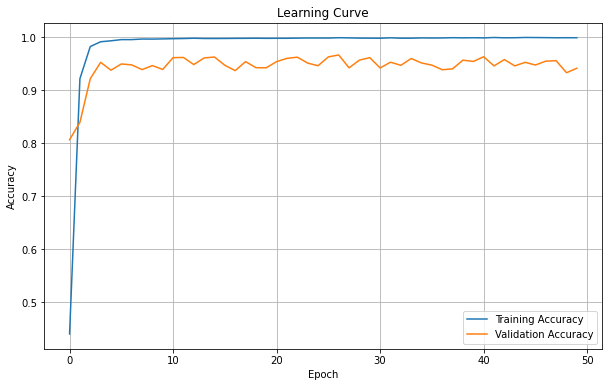

Test Accuracy: 0.9743446737311768 
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       154
           B       1.00      1.00      1.00       220
           C       1.00      1.00      1.00       156
           D       1.00      0.96      0.98       118
           E       0.99      1.00      1.00       254
           F       1.00      1.00      1.00       124
           G       0.87      0.99      0.93       164
           H       1.00      0.96      0.98       219
           I       0.94      1.00      0.97       134
           K       0.93      1.00      0.96       171
           L       1.00      1.00      1.00       109
           M       1.00      0.99      0.99       195
           N       0.98      0.85      0.91       140
           O       1.00      1.00      1.00       127
           P       1.00      1.00      1.00       171
           Q       1.00      1.00      1.00        81
           R       1.00

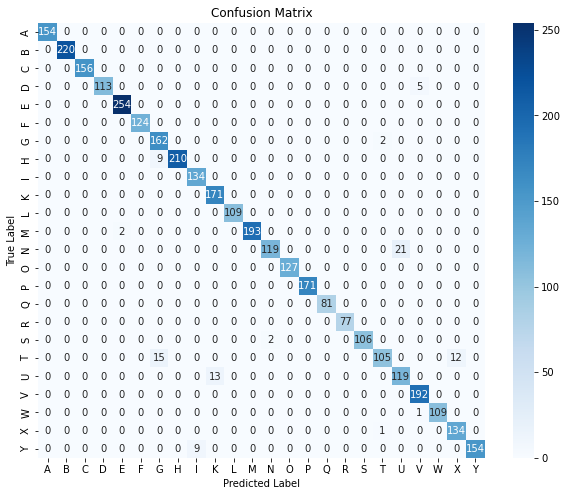

A: 1.0000
B: 1.0000
C: 1.0000
D: 0.9576
E: 1.0000
F: 1.0000
G: 0.9878
H: 0.9589
I: 1.0000
J: nan
K: 1.0000
L: 1.0000
M: 0.9897
N: 0.8500
O: 1.0000
P: 1.0000
Q: 1.0000
R: 1.0000
S: 0.9815
T: 0.7955
U: 0.9015
V: 1.0000
W: 0.9909
X: 0.9926
Y: 0.9448
Z: nan
Classification report, class-wise accuracies, and confusion matrix plot saved.


C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [73]:

def create_complex_cnn_model(optimizer='adam', learn_rate=0.01):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),  # Additional convolutional layer
        layers.MaxPooling2D((2, 2)),

        #layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Conv2D(128, (3, 3), activation='relu'),  # Additional convolutional layer
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

        layers.Dense(500, activation='relu'),
        layers.Dropout(0.5),  # Adding dropout for regularization

        layers.Dense(256, activation='relu'),  # Additional dense layer
        layers.Dropout(0.3),  # Adding dropout for regularization

        layers.Dense(26, activation='softmax')  # Output layer with 26 classes (letters A-Z)
    ])

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model
train_x,train_y,val_x,val_y,test_x,test_y = prep_datasets(TRAIN_X,TRAIN_Y,TEST_X,TEST_Y)
# Evaluate the model on the validation set with the best hyperparameters  {'activation': 'relu', 'optimizer': 'rmsprop'}
# best_params = {'optimizer':'rmsprop','learn_rate': .001}

class_weights = compute_class_weight('balanced', classes=np.unique(TRAIN_Y), y=TRAIN_Y)
class_weight_dict = {class_idx: weight for class_idx, weight in enumerate(class_weights)}

subdirectory ="Results/weighted_CNN"

path = os.path.join(directory, subdirectory)

best_model = create_complex_cnn_model(optimizer=best_params['optimizer'], learn_rate=best_params['learn_rate'])

# Add Early Stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Add ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(str(path+'weighted_best_model.h5'), monitor='val_accuracy', save_best_only=True, mode='max')

history = best_model.fit(train_x, train_y, validation_data=(val_x, val_y), callbacks=[ model_checkpoint],epochs=50, batch_size=64, verbose=1)

model = tf.keras.models.load_model(path+'weighted_best_model.h5')

#path = directory+ "weighted_CNN"
# Plot the learning curve
plt_curve(history,path)


# Model performance Evaluation
weighted_res = model_eval(path,model,test_x,test_y)

### The clients Metrices:
Model: Weighted CNN- More Complex architecture with added class weight training parameter

unbiased accuracy estimate of a deep learning model: **97.43%**

the letter with the lowest individual accuracy: **79.55%  For letter t**

the most common error: **Confussion between N and U** (21 instances in total, Evidednt from the Confussion metrix)

### Model Comparison
**Class/ Letter-wise Accuracy Comparison**
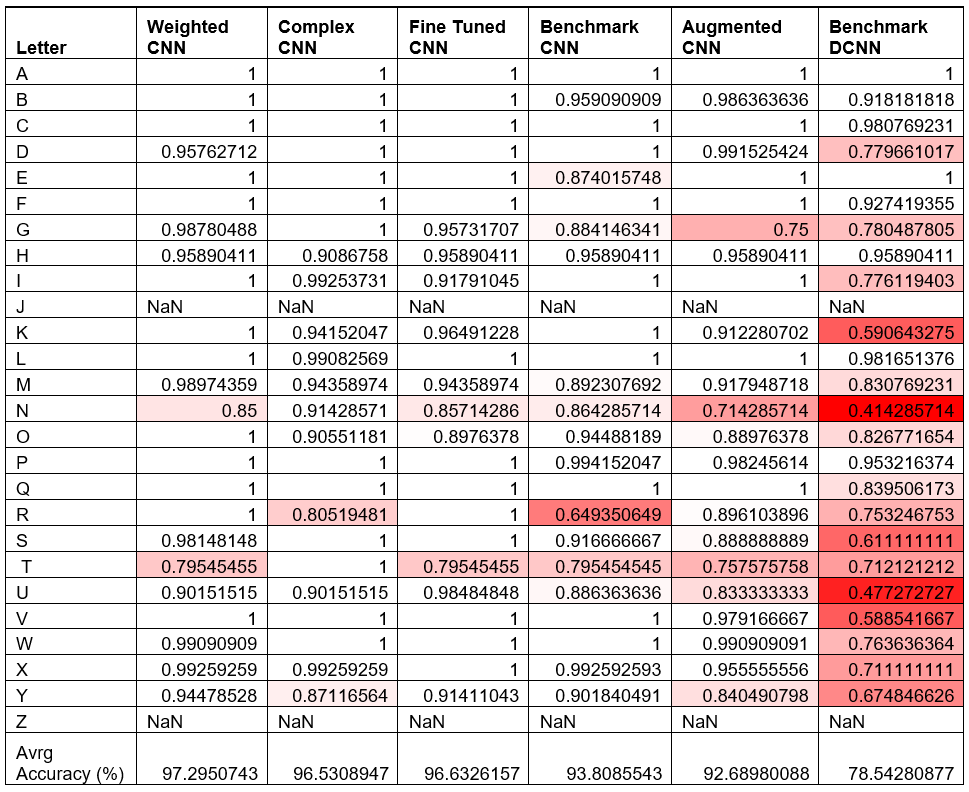



### Result analysis

All the traing runs has these parameters
*   Epoch = 50
*   Batch Size = 64
*   50% of the test set is used as Evaluation set rest as final testing set
*   In no stage, the contents of the test set effect training procedure.
*   Total Number of traing run performed is (6+27), 6 for different interation of models and 27 for grid searching algorithm to find the optimum training paramters



**Overall testing accuracy accross differernt models**

*   Class weighted CNN : **97.43%**
*   Complex CNN : **96.74%**
*   Hyper paramerter tuned Benchmark CNN: **96.65%**
*   Benchmark CNN:  **94.09%**
*   Benchmark CNN with augmented dataset: **92.95%**
*   Benchmark DCNN: **79.76%**

**Letters with lowest Accuracy:**
*   Class weighted CNN : **79.55%** for Letter **T**
*   Complex CNN : **80.52%%** for Letter **R**
*   Hyper paramerter tuned Benchmark CNN: **79.55%** for letter **T**
*   Benchmark CNN:  **64.94%** for letter **R**
*   Benchmark CNN with augmented dataset: **71.43%** for letter **N**
*   Benchmark DCNN: **41.43%** for letter **N**

**Weighted Average F1 Score**
*   Class weighted CNN : **0.97**
*   Complex CNN : **0.97**
*   Hyper paramerter tuned Benchmark CNN: **0.95**
*   Benchmark CNN:  **0.94**
*   Benchmark CNN with augmented dataset: **0.92**
*   Benchmark DCNN: **0.78**

**Most Common Errors are**
*   Confussion between N and U -21 instances - Weighted CNN
*   Confussion between Y and I -21 instances - Complex CNN
*   Confussion between T and X -27 instances - Fine Tuned CNN  
*   Confussion between Y and I -25 instances - Augmented CNN
*   Confussion between R and K -37 instances - DCNN
*   Confussion between E and S -32 instances - CNN

**Observation**
1. Accross all models N has the lowest average accuracy
2. Accross all models The most common error is Confussion between Y and I.
3. Accross all models The accuracy of the Letters **N** and **T** are lower then others.

  


### Statistical Comparison between best model: Paired t-test

Test Accuracy: 0.9673731176798661 
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       154
           B       1.00      1.00      1.00       220
           C       0.95      1.00      0.97       156
           D       1.00      1.00      1.00       118
           E       0.96      1.00      0.98       254
           F       1.00      1.00      1.00       124
           G       0.87      1.00      0.93       164
           H       1.00      0.91      0.95       219
           I       0.86      0.99      0.92       134
           K       0.86      0.94      0.90       171
           L       1.00      0.99      1.00       109
           M       0.94      0.94      0.94       195
           N       1.00      0.91      0.96       140
           O       1.00      0.91      0.95       127
           P       0.94      1.00      0.97       171
           Q       1.00      1.00      1.00        81
           R       1.00

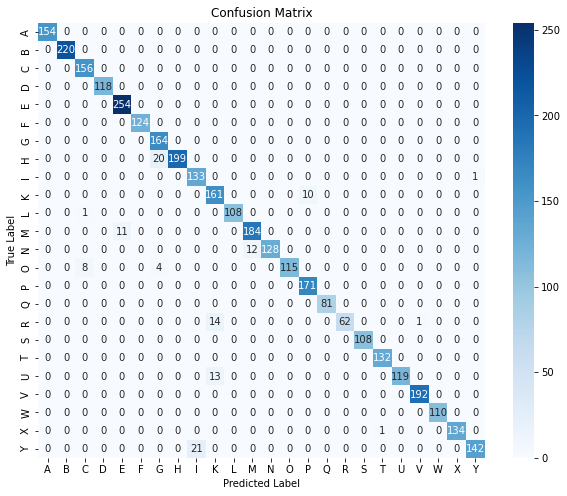

A: 1.0000
B: 1.0000
C: 1.0000
D: 1.0000
E: 1.0000
F: 1.0000
G: 1.0000
H: 0.9087
I: 0.9925
J: nan
K: 0.9415
L: 0.9908
M: 0.9436
N: 0.9143
O: 0.9055
P: 1.0000
Q: 1.0000
R: 0.8052
S: 1.0000
T: 1.0000
U: 0.9015
V: 1.0000
W: 1.0000
X: 0.9926
Y: 0.8712
Z: nan
Classification report, class-wise accuracies, and confusion matrix plot saved.


C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test Accuracy: 0.9743446737311768 
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       154
           B       1.00      1.00      1.00       220
           C       1.00      1.00      1.00       156
           D       1.00      0.96      0.98       118
           E       0.99      1.00      1.00       254
           F       1.00      1.00      1.00       124
           G       0.87      0.99      0.93       164
           H       1.00      0.96      0.98       219
           I       0.94      1.00      0.97       134
           K       0.93      1.00      0.96       171
           L       1.00      1.00      1.00       109
           M       1.00      0.99      0.99       195
           N       0.98      0.85      0.91       140
           O       1.00      1.00      1.00       127
           P       1.00      1.00      1.00       171
           Q       1.00      1.00      1.00        81
           R       1.00

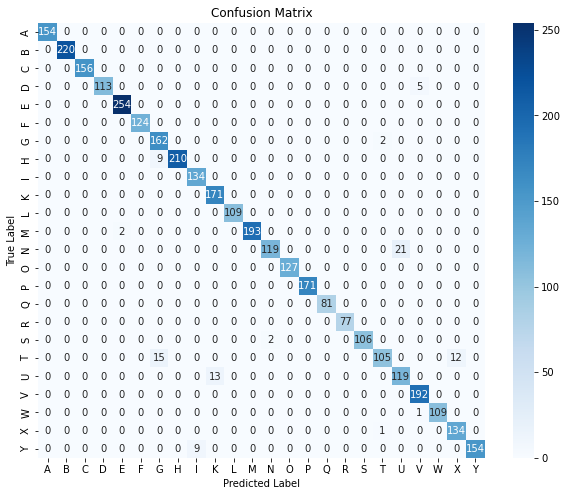

A: 1.0000
B: 1.0000
C: 1.0000
D: 0.9576
E: 1.0000
F: 1.0000
G: 0.9878
H: 0.9589
I: 1.0000
J: nan
K: 1.0000
L: 1.0000
M: 0.9897
N: 0.8500
O: 1.0000
P: 1.0000
Q: 1.0000
R: 1.0000
S: 0.9815
T: 0.7955
U: 0.9015
V: 1.0000
W: 0.9909
X: 0.9926
Y: 0.9448
Z: nan
Classification report, class-wise accuracies, and confusion matrix plot saved.
[0.9759485204401175, 0.9729507430854983, 0.9734512335280621, 0.9743446737311768]
[0.9733391091528237, 0.9653089471167773, 0.9678080064256133, 0.9673731176798661]
Paired t-test:
t-statistic: 5.123024865922609
p-value: 0.014398301374043482
The difference is statistically significant.


C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\user\anaconda3\envs\MSC_PROJ\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:

# Load the saved models and run evalution 
train_x,train_y,val_x,val_y,test_x,test_y = prep_datasets(TRAIN_X,TRAIN_Y,TEST_X,TEST_Y)


subdirectory ="Results/Complex_CNN"
path = os.path.join(directory, subdirectory)
complex_model = tf.keras.models.load_model(path+'complex_best_model.h5')
# Model performance Evaluation
complex_res = model_eval(path,complex_model,test_x,test_y)


subdirectory ="Results/weighted_CNN"
path = os.path.join(directory, subdirectory)
weighted_model = tf.keras.models.load_model(path+'weighted_best_model.h5')
# Model performance Evaluation
weighted_res = model_eval(path,weighted_model,test_x,test_y)


print(weighted_res)
print(complex_res)

# Perform the paired t-test
t_statistic, p_value = stats.ttest_rel(weighted_res, complex_res)

print("Paired t-test:")
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")

# Determine if the difference is statistically significant
alpha = 0.05
if p_value < alpha:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")


**Best Two Model Comparison**
In previous cell we have seen that by commencing T test,we have found that Class Weighted CNN is statistically better then complex CNN. 

So the **Class Weighted CNN.** is better for following reasons

1.   It has the Highest overall test accuracy.
2.   It has Best average F1 Score.
3.   It has least number of letters with less then 90% accuracy.

N.B: The training for all models were done on GTX 960M GPU.
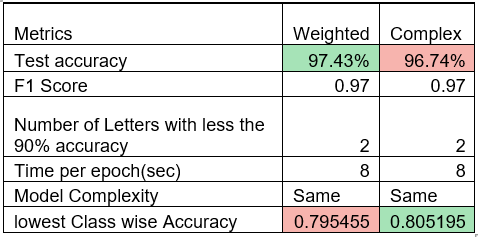


**The Saved Models, Learning Curves, Confussion matrix and Classification Report are included in the Results Folder**

**Recommedations**
1.   Augmentation improves the accuracy of certain letters but diminishes the accuracy of others
2.   Accuracy of some letters are suffering from sampling bias. to better understand the performance of the model. F1 score should be looked at.